# EMBC 2023

## Load libraries

In [1]:
import json

# import matplotlib as mpl
# print( mpl.rcParams['axes.titlesize'] )
# print( mpl.rcParams['axes.titleweight'] )
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from lib.metrics import BalancedSparseCategoricalAccuracy
from lib.generator import WindowGenerator

np.random.seed(4)

ModuleNotFoundError: No module named 'lib'

## Load configuration

In [14]:
# Garmin features
columns = ['timestamp', 'heart_rate', 'steps', 'stress_score',
           'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
#   'timestamp_hour'
# columns += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

target_column = 'wearing_off'
columns.append(target_column)

# Normalize features
normalize_features = ['heart_rate', 'steps', 'stress_score',
                      'awake', 'deep', 'light', 'rem',
                      'nonrem_total', 'total',
                      'nonrem_percentage', 'sleep_efficiency',
                      'timestamp_hour_sin', 'timestamp_hour_cos']

participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

BATCH_SIZE = 1 # 8
MAX_EPOCHS = 100
LEARNING_RATE = 1e-3
SHIFT = 4
USE_HOURLY = False
USER = 'participant13'
INTERVAL = '15min'

## Load data

In [15]:
# Load participant's Excel file
dataset = pd.read_excel(f'./data/4-combined_data_{USER}_{INTERVAL}.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl')

### Fill missing data & filter data

In [16]:
# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter data based on participant's dictionary
dataset = dataset.loc[
    (dataset.index >= participant_dictionary[USER]['start_date']) &
    (dataset.index < participant_dictionary[USER]['end_date_plus_two'])
]

### Slice data to hourly data

In [ ]:
# Convert data into hourly interval
if USE_HOURLY:
  # Slice [start:stop:step], starting from index 0, take every 4 record
  # Take every hour record only
  dataset = dataset[::4].copy() 

  # Fix columns arrangement
  record_size_per_day = 24

## Visualize data with wearing-off periods

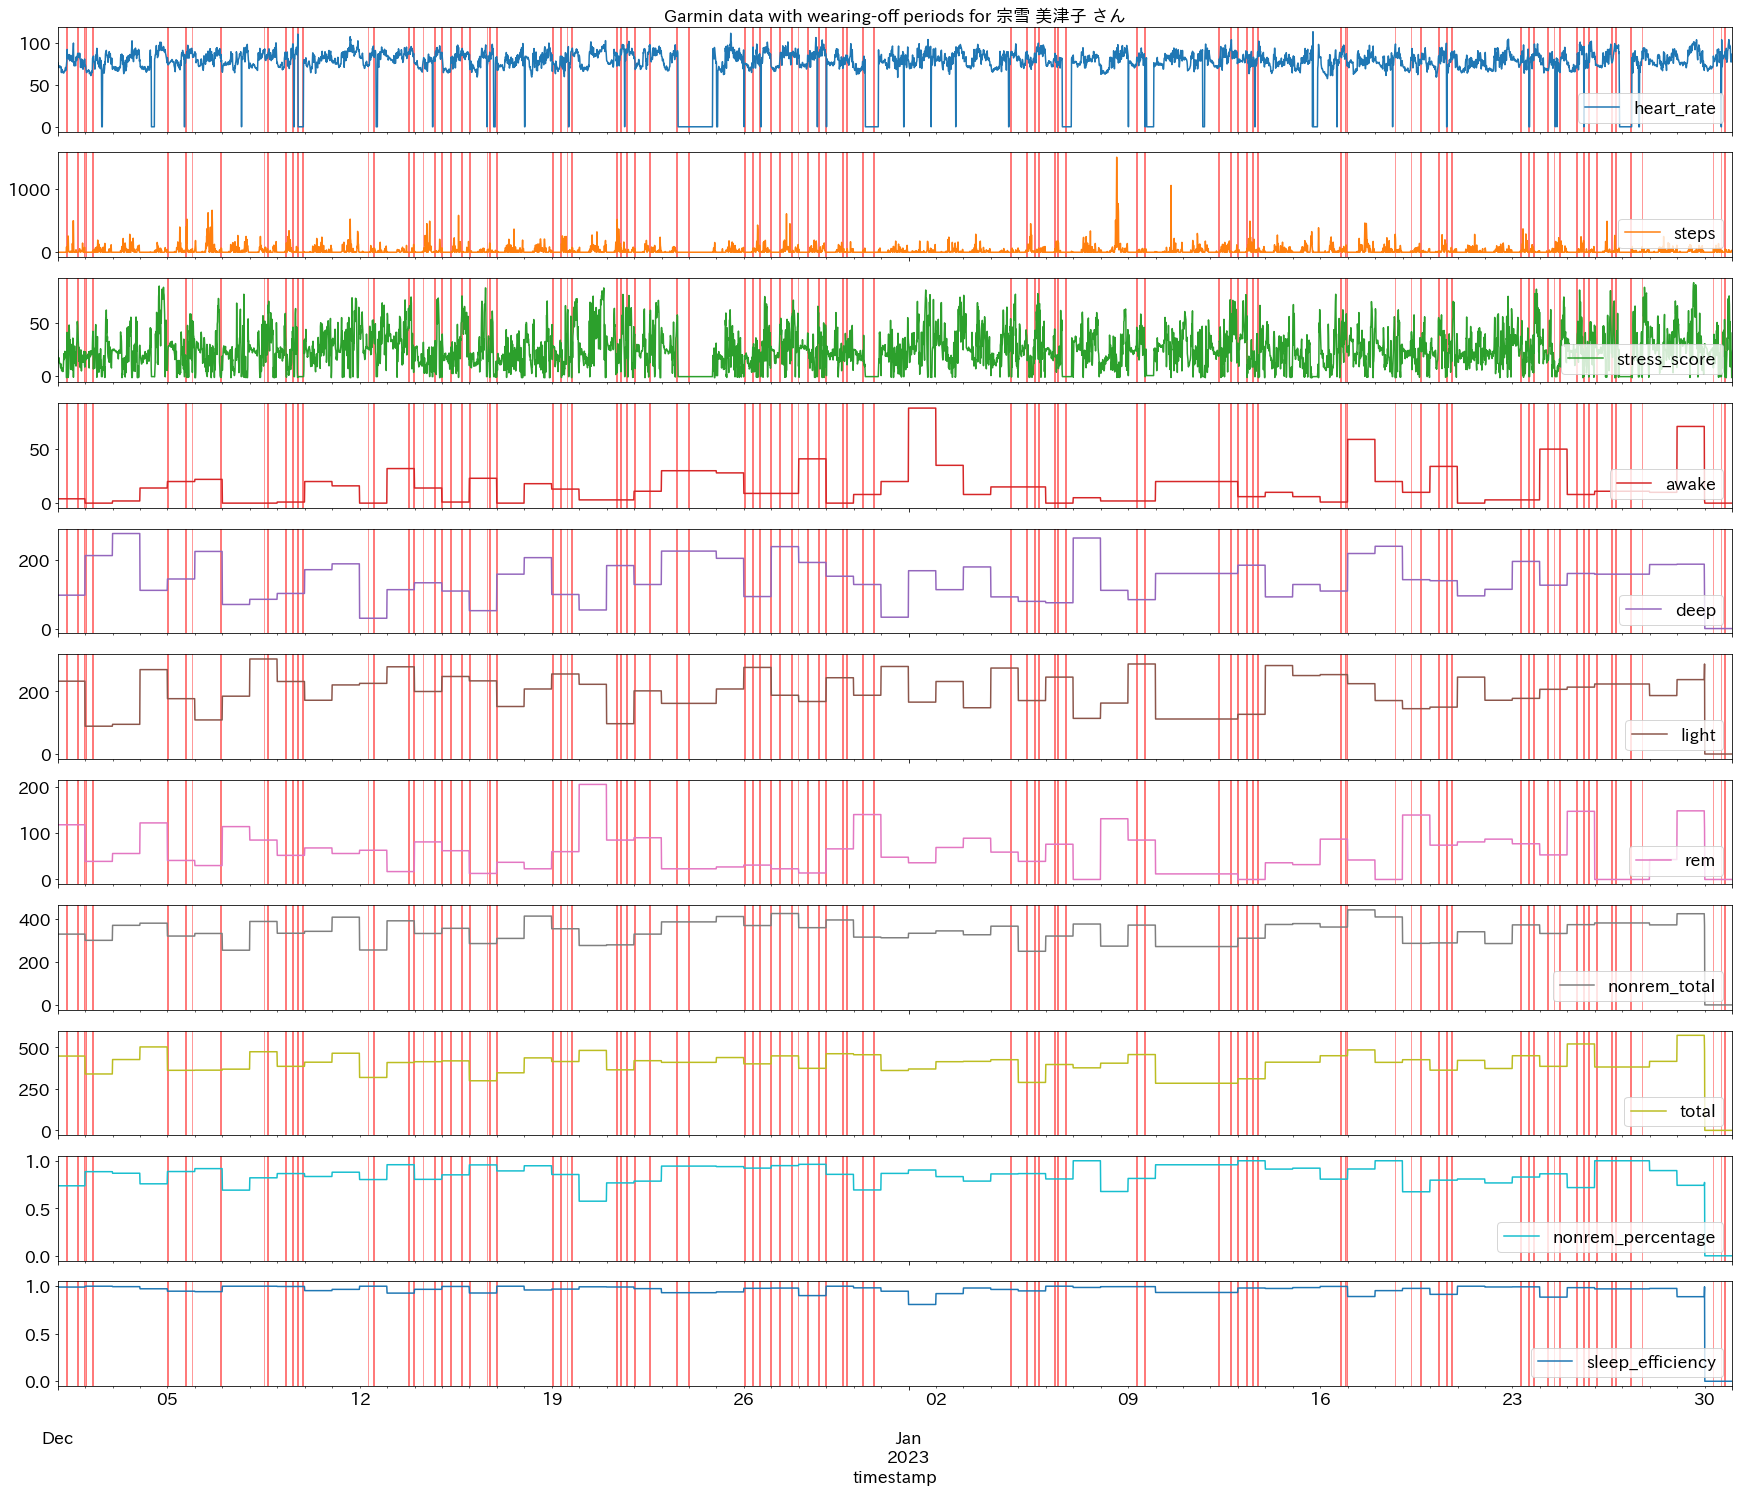

In [17]:
FIGSIZE = (30,25)
axes = dataset.loc[:, dataset.columns != target_column].plot(
    subplots=True, figsize=FIGSIZE )
for index, axis in enumerate(axes):
    if index == 0:
        axis.set_title(
            label='Garmin data with wearing-off periods for 宗雪 美津子 さん'.format(
                USER.replace("participant", "")
            ),
            fontdict={
                'fontsize': 'xx-large',
                'fontweight': 'bold'
            }
        )

    column = dataset.columns[index]
    min_value = dataset[[column]].min()
    max_value = dataset[[column]].max()

    axis.fill_between(
        x=dataset.index, y1=min_value, y2=max_value, 
        where=dataset.wearing_off, 
        alpha=0.4, color="red", transform=axis.get_xaxis_transform()
    )
    axis.legend([column], loc="lower right", fontsize='xx-large')
    axis.tick_params(axis='both', which='both', labelsize='xx-large')
    axis.set_xlabel(xlabel=dataset.index.name, fontsize='xx-large')

# plt.savefig(f'./results/{USER}_wearing_off.pdf')
# plt.show()

## Summary of data

In [ ]:
dataset.describe().transpose().round(3)

## Split data

In [ ]:
# training data 60% 
TRAINING_PERCENTAGE = 0.6
# validation data 20%
VALIDATION_PERCENTAGE = 0.2

record_size_per_day = 96

column_indices = { name: i for i, name in enumerate(dataset.columns) }
total_rows = len(dataset)
num_features = len(dataset.columns)

training_end_index = int(total_rows * TRAINING_PERCENTAGE)
validation_end_index = int(total_rows * (TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE))

train_df = dataset[0:training_end_index].copy()
validation_df = dataset[training_end_index:validation_end_index].copy()
test_df = dataset[validation_end_index:].copy()

print(f"Training data: {round(len(train_df)/record_size_per_day, 3)} days")
print(f"Validation data: {round(len(validation_df)/record_size_per_day, 3)} days")
print(f"Test data: {round(len(test_df)/record_size_per_day, 3)} days")
print(f"Total data: {round(len(dataset)/record_size_per_day, 3)} days")

train_mean = train_df.loc[:, normalize_features].mean()
train_std = train_df.loc[:, normalize_features].std()

train_df.loc[:, normalize_features] = (train_df.loc[:, normalize_features] - train_mean) / train_std
validation_df.loc[:, normalize_features] = (validation_df.loc[:, normalize_features] - train_mean) / train_std
test_df.loc[:, normalize_features] = (test_df.loc[:, normalize_features] - train_mean) / train_std

df_standardized = (dataset.loc[:, normalize_features] - train_mean) / train_std
df_standardized = pd.merge(df_standardized, dataset.iloc[:, -2:], left_index=True, right_index=True)
df_standardized = df_standardized.melt(var_name='Columns', value_name='Normalized')
plt.figure(figsize=FIGSIZE)
ax = sns.violinplot(x='Columns', y='Normalized', data=df_standardized)
_ = ax.set_xticklabels(dataset.keys(), rotation=45)
plt.title("Distribution of normalized features")
# plt.savefig(f'./results/{user}_distribution_normalized_data.pdf')
plt.show()

## Window Generator

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=1,
                     train_df=train_df, validation_df=validation_df, test_df=test_df,
                     label_columns=['wearing_off'])
w1.plot(plot_col="wearing_off")

In [ ]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=SHIFT,
                                     train_df=train_df, validation_df=validation_df, test_df=test_df,
                                     label_columns=['wearing_off'])

wide_single_step_window = WindowGenerator(input_width=24, label_width=24, shift=SHIFT,
                              train_df=train_df, validation_df=validation_df, test_df=test_df,
                              label_columns=['wearing_off'])

MULTI_STEP_WIDTH = 24 # t0, t1, t2, ..., t24
multi_step_window = WindowGenerator(input_width=MULTI_STEP_WIDTH, label_width=1, shift=SHIFT,
                                    train_df=train_df, validation_df=validation_df, test_df=test_df,
                                    label_columns=['wearing_off'])

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (MULTI_STEP_WIDTH - 1)
wide_multi_step_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                                         train_df=train_df, validation_df=validation_df, test_df=test_df,
                                         label_columns=['wearing_off'])

## Compile & Fit

In [ ]:
MAX_EPOCHS = 100
validation_performance = {}
test_performance = {}

def brier_score(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred))

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  # model.compile(loss=brier_score,
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)

  history = model.fit(window.train(True), epochs=MAX_EPOCHS,
                      validation_data=window.validation(True),
                      callbacks=[early_stopping])
  return history

## Models

### Baseline

In [ ]:
model_name = 'Baseline'

K.clear_session()
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
        return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
  
baseline = Baseline(label_index=column_indices['wearing_off'])
baseline.compile(loss=brier_score,
                 metrics=METRICS)

validation_performance[model_name] = baseline.evaluate(single_step_window.validation(False))
test_performance[model_name] = baseline.evaluate(single_step_window.test(False), verbose=1)

In [ ]:
# Classification report
predictions = []
labels = []
for input, label in single_step_window.test(False):
    output = baseline(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))

# Visualize
wide_single_step_window.plot(baseline, override=True)
print(
    classification_report(predictions, labels,
                        target_names=['normal', 'wearing-off'],
                        output_dict=False)
)

# Confusion Matrix
cm = confusion_matrix(predictions, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
disp.plot()
plt.title(f'Confusion matrix for Participant {USER.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
plt.show()

### Linear model

In [ ]:
model_name = "Linear"

K.clear_session()
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

history = compile_and_fit(linear, single_step_window)

validation_performance[model_name] = linear.evaluate(single_step_window.validation())
test_performance[model_name] = linear.evaluate(single_step_window.test(), verbose=1)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {USER.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

In [ ]:
# Classification report
predictions = []
labels = []
for input, label in single_step_window.test():
    output = linear(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

# Visualize
wide_single_step_window.plot(linear, override=False)
print(
    classification_report(predictions, labels,
                        target_names=['normal', 'wearing-off'],
                        output_dict=False)
)

# Confusion Matrix
cm = confusion_matrix(predictions, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
disp.plot()
plt.title(f'Confusion matrix for Participant {USER.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
plt.show()